# Hyper-minimization of DFAs

### Imports

##### Automata Lib

Importing and configuring the automata library used in this notebook.

In [1]:
from automata.fa.dfa import DFA
import automata.base.config as global_config

global_config.allow_mutable_automata = True
global_config.should_validate_automata = False

##### Collections

In [2]:
from collections import defaultdict, deque

##### Performance profiling

Importing the necessary libraries for profiling the performance of the code and the different hyper-minimization algorithms.

In [3]:
import timeit
import speedscope
import random
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import math

In [4]:
%reload_ext pyinstrument

### Utils

This section contains utility functions that are used in the hyper-minimization algorithms.

##### Breadth-first search

This function performs a breadth-first search on the given DFA starting from the given state and returns the set of states that are reachable from the given state. It is well-known that the BFS algorithm has a time complexity of $O(n + m)$, where $n$ is the number of vertices and $m$ is the number of edges, however, in the case of DFAs, the number of edges is linear in the number of states, so the time complexity of the BFS algorithm is $O(n)$.

In [5]:
def breadth_first_search(dfa: DFA, initial) -> set:
  """
  Breadth-first search on the DFA from the initial state.
  O(n * m) time complexity, where n is the number of states and m is the number of input symbols.
  """
  # Note: added this small change so that the initial state is not added if 
  # not reachable from other states reachable from it
  cold_start = True

  # classic BFS
  visited = set()
  queue = deque([initial])
  
  while queue:
    current = queue.popleft()

    # skips states already visited, this can happen if a state has been added to the queue multiple times
    if current not in visited: 

      # removes the cold start flag at the first iteration
      if not cold_start:
        visited.add(current)
      else:
        cold_start = False

      # expands the current state
      for symbol in dfa.input_symbols:
        next = dfa.transitions[current][symbol]
        if next not in visited:
          queue.append(next)

  return visited

##### Incremental DFA (builder)

An `IncrementalDFA` class is defined that aims to build a DFA incrementally, i.e. it can be used to build DFAs that are not known in advance which during construction are not correct. This class is used in the hyper-minimization algorithms to build the DFA that is being hyper-minimized. This is mainly created because, although the automata library flag `allow_mutable_automata` is set to `True`, the `minify` method returns an immutable DFA.

In [6]:
class IncrementalDFA:
  def __init__(self, dfa: DFA = None, deep_copy = False):
    """
    Initialize an incremental DFA.
    """
    if dfa is None:
      self.__empty_init()
    else:
      self.states = set(dfa.states)
      self.transitions = dict(dfa.transitions)
      if deep_copy:
        for key in self.transitions.keys():
          self.transitions[key] = dict(self.transitions[key])   
      self.initial_state = dfa.initial_state
      self.final_states = set(dfa.final_states)
      self.input_symbols = set(dfa.input_symbols)

  def __empty_init(self):
    """
    Initialize an empty incremental DFA.
    """
    self.states = set()
    self.transitions = dict()
    self.initial_state = None
    self.final_states = set()
    self.input_symbols = set()

  def build(self) -> DFA:
    """
    Build and returns the DFA.
    """
    return DFA(
      states=self.states,
      input_symbols=self.input_symbols,
      transitions=self.transitions,
      initial_state=self.initial_state,
      final_states=self.final_states
    )

### Hyper-minimization algorithms

##### Badr, Geffert & Shipman algorithm

The first implemented algorithm is the one described in the [original paper](http://www.numdam.org/article/ITA_2009__43_1_69_0.pdf) regarding the hyper minimization of DFAs by Andrew Badr, Viliam Geffert and Ian Shipman. Given a DFA $A = (Q, \Sigma, \delta, q_0, F)$, the algorithm returns the hyper-minimized DFA $A'' = (Q'', \Sigma, \delta'', q_I'', F'')$ in time $O(n^3 \cdot m)$, where $n$ is the number of states $||Q||$ and $m$ is the number of symbols in the input alphabet $||\Sigma||$.

In [135]:
def badr_geffert_shipman_hyper_minimize(dfa: DFA) -> DFA:
  """ 
  Hyper-minimize a DFA using the Badr-Geffert-Shipman algorithm.
  """
  # step 1: minimization of the DFA
  # note: the DFA is deep copied (casted) into an IncrementalDFA to allow the modifications needed by the algorithm
  mdfa = IncrementalDFA(dfa.minify(retain_names=True), deep_copy=True)

  # step 2 (pre-processing): analysis of the reachability in the transition graph (construction of the E matrix)
  # note: the E matrix is represented by a dictionary of sets, each state represents a row of the matrix, each set contains
  # the values of the row which should be set to 1 in the matrix. This modification is needed in order to perform the 
  # successive step of the algorithm which checks E[1][j] which is not directly possible using integer indexes because
  # the DFA states are represented by a set and the first state is not necessarily the first element of the set.
  E = {q:breadth_first_search(mdfa, q) for q in mdfa.states}

  # step 3: kernel states identification, made easy by the E matrix (computed in the previous step)
  K = {q for q in mdfa.states if any([r in E[mdfa.initial_state] and r in E[r] and q in E[r] for r in mdfa.states])}

  # step 4: almost-equivalence relation computation

  # initial partitioning of the states Q = {q_1} ∪ {q_2} ∪ ... ∪ {q_n}
  P = {q:q for q in mdfa.states}
  states = list(mdfa.states) # needed to slice the states list
  while True:
    # flag used to exit the loop if no almost-equivalent states are found
    ae_found = False
    # searches for couples of states q_i1 and q_i2, with i1 ≠ i2, that are not already in the same set of the partition P
    for i, q1 in enumerate(states):
      for q2 in states[i+1:]:
        if P[q1] != P[q2]:
          ae = all(P[mdfa.transitions[q1][sigma]] == P[mdfa.transitions[q2][sigma]] for sigma in mdfa.input_symbols)
          if ae:
            for q in states:
              if P[q] == P[q2]:
                P[q] = P[q1]
            ae_found = True
    # if no almost-equivalent states are found, the loop is exited
    if not ae_found:
      break

  # step 5: hyper-minimization of the DFA (useless states removal)

  # iterates over the sets of the partition
  # note: since to each key of the partition dict, which is the name of the state, corresponds tha name of
  # the set to which the state belongs, casting the valoues of the dict to a set allows to execute
  # one and only one iteration for each set of the partition
  for curr_set in set(P.values()):

    # computes the preamble and kernel states of the current set of the partition
    kernels, preambles = [], []
    for q in mdfa.states:
      if P[q] == curr_set:
        kernels.append(q) if q in K else preambles.append(q)

    # selects the state to which the preamble states will be redirected

    # note: if the first condition is false, means that the set is composed only of kernel states so no state can be removed,
    # the nested if statement is used to select the state to which the preamble states will be redirected: if the set contains
    # both preamble and kernel states, the redirect state is a kernel state, otherwise it is a preamble state
    if len(preambles) != 0: 
      r = kernels[0] if len(kernels) != 0 else preambles.pop(0)

    # removes the useless states
    for q in preambles:
      # removes the state and its row into the transitions table
      mdfa.states.remove(q)
      del mdfa.transitions[q]

      # redirects the edges going into the removed state to the redirect state
      for s in mdfa.states:
        for sigma in mdfa.input_symbols:
          if mdfa.transitions[s][sigma] == q:
            mdfa.transitions[s] = dict(mdfa.transitions[s])
            mdfa.transitions[s][sigma] = r

      # updates the initial state with the redirect sstate if the removed one was the initial state
      if q == mdfa.initial_state:
        mdfa.initial_state = r
      # removes the state from the final states set if it was a final state
      if q in mdfa.final_states:
        mdfa.final_states.remove(q)
  
  return mdfa.build()

##### Badr algorithm

The second implemented algorithm is the one described in [this paper](https://www.andrewbadr.com/files/hyper/ciaa32.pdf) by Andrew Badr. The idea behind the algorithm is to use the $A^\otimes$ automaton, result of the XOR operation between the input DFA $A = (Q, \Sigma, \delta, q_0, F)$ and itself, to determine the almost-equivalence relation between the states in $A$ which happens to be the states $(q_A, q_B)$ in $A^\otimes$ that induce a finite language in $A^\otimes$. This strategy improves the time complexity of the previous algorithm to $O(n^2)$.

In [8]:
class QuickFind:
  def __init__(self):
    """
    Initializes an empty partition.
    """
    self.parent               = dict() # parent[q_i] contains the name of the set to which q_i belongs
    self.sets: dict[any:set]  = dict() # sets[set_name] contains the elements of the set which name is set_name
  
  def make_set(self, element):
    """
    Creates and adds a new singleton set containing the given element.
    """
    self.parent[element]  = element
    self.sets[element]    = {element}

  def find(self, element):
    """
    Finds and returns the name of the set containing the given element.
    """
    return self.parent[element] if element in self.parent else None
  
  def union(self, a, b):
    """
    Merges the sets which names are x and y.
    """
    # one of the sets does not exists or they are the same set
    if a not in self.sets or b not in self.sets or a == b:
      return
    
    a, b = (a, b) if len(self.sets[a]) > len(self.sets[b]) else (b, a)
    
    for element in self.sets[b]:
      self.parent[element] = a
      self.sets[a].add(element)

    del self.sets[b]

  def parts(self):
    """
    Iterates over the sets of the partition.
    """
    for s in self.sets.values():
      yield s

  def partition(self):
    """
    Returns the partition as a set of sets.
    """
    return list(self.sets.values())

In [9]:
def xor_cross_product(dfa_1: IncrementalDFA, dfa_2: IncrementalDFA) -> IncrementalDFA:
  """
  Computes the cross product between two DFAs.
  """
  dfa_xor = IncrementalDFA()
  dfa_xor.input_symbols = set(dfa_1.input_symbols)
  dfa_xor.initial_state = (dfa_1.initial_state, dfa_2.initial_state)
  dfa_xor.transitions = defaultdict(dict)

  # computes the cross product DFA attributes
  for q_1 in dfa_1.states:
    for q_2 in dfa_2.states:
      state = (q_1, q_2)

      # computes the states of the cross product DFA
      dfa_xor.states.add(state)

      # computes the final states of the cross product DFA
      if (q_1 in dfa_1.final_states) != (q_2 in dfa_2.final_states): # corresponds to the xor operation
        dfa_xor.final_states.add(state)

      # computes the transitions of the cross product DFA
      for symbol in dfa_1.input_symbols:
        dfa_xor.transitions[state][symbol] = (dfa_1.transitions[q_1][symbol], dfa_2.transitions[q_2][symbol])

  # creates and returns the cross product DFA
  return dfa_xor

In [10]:
def right_finite_state(dfa: IncrementalDFA, S: set) -> list:
  """
  Computes the subset F of Q of all states of the DFA that induce a finite language.
  """
  # computes the set S' = Q \ S and initializes incoming and outgoing edges sets for each state
  S_prime = set(dfa.states) - S
  incoming = defaultdict(set)
  outgoing = defaultdict(set)

  # computes the incoming and outgoing edges for each state in S'
  for q in S_prime:
    for c in dfa.input_symbols:
      q_prime = dfa.transitions[q][c]
      incoming[q_prime].add((q, c))
      outgoing[q].add((q_prime, c))

  # computes the subset F of Q of all states that induce a finite language
  F = list()
  to_process = deque(S)
  while to_process:
    q = to_process.popleft()
    F.append(q)
    
    for q_prime, c in incoming[q]:
      outgoing[q_prime].remove((q, c))
      if not outgoing[q_prime]:
        to_process.append(q_prime)

  return F

In [11]:
def f_equivalence_classes(dfa: IncrementalDFA) -> QuickFind:
  """ 
  Computes a partition of the states of the DFA into almost-equivalnce classes.
  """
  # computes the cross-product of the DFA with itself
  D_xor = xor_cross_product(dfa, dfa)
  
  # computes the set S = {(q, q) | q ∈ Q} which is the set of all self-pair states in the cross-product
  S = {(q, q) for q in dfa.states}

  # computes the set of all states (q, r) in  the cross-product such that (q, r) induces a finite language in the cross-product
  F = right_finite_state(D_xor, S)

  # computes the partition
  P = QuickFind()
  for q in dfa.states:
    P.make_set(q)
  for q, r in F:
    P_q = P.find(q)
    P_r = P.find(r)
    if P_q != P_r:
      P.union(P_q, P_r)
  
  return P

In [12]:
def preamble_and_kernel(dfa: IncrementalDFA) -> tuple[set, set]:
  """
  Computes the preamble set and the kernel set of states of the DFA.
  """
  # note: a basic observation points out that all the function can be computes into a single for loop over the states
  # without storing each set saving memory and time complexity

  # initializes the kernel set
  K = set()

  for q in dfa.states:
    # computes the set of states non trivially reachable from q_i
    R = breadth_first_search(dfa, q)
    # if q_i is a kernel state, add all the states non trivially reachable from q_i to the kernel set
    if q in R:
      K = K.union(R)

  return (dfa.states - K, K)

In [13]:
def f_merge_states(dfa: IncrementalDFA, E: QuickFind, P: set, K: set):
  """
  Computes the hyper-minimal DFA obtained by merging the states of the DFA according to the almost-equivalence relation
  and the preamble and kernel sets.
  """
  # iterates over the sets of the partition (almost-equivalence classes)
  for S in E.parts():

    # computes the preamble and kernel states of the current set of the partition
    P_S = S.intersection(P)
    K_S = S.intersection(K)

    # selects the state to which the preamble states will be redirected
    if K_S:
      R = K_S.pop()
    else:
      R = P_S.pop()

    # removes the useless states
    for q in P_S:
      # merge q into R
      dfa.states.remove(q)   # state is removed from the set of states
      del dfa.transitions[q] # transitions from the state are removed

      # redirects the edges going into the removed state to the redirect state
      for q_prime in dfa.states:
        for symbol in dfa.input_symbols:
          if dfa.transitions[q_prime][symbol] == q:
            dfa.transitions[q_prime][symbol] = R

      # finally, if the removed state was the initial state, the redirect state becomes the new initial state
      # and if the removed state was a final state, the redirect state becomes a final state and the removed state is
      # removed from the final states set
      if q == dfa.initial_state:
        dfa.initial_state = R
      if q in dfa.final_states:
        dfa.final_states.remove(q)

In [14]:
def badr_hyper_minimize(dfa: DFA) -> DFA:
  """
  Hyper-minimize a DFA using the Badr algorithm.
  """
  # step 1: minimization of the DFA
  minimal_dfa = IncrementalDFA(dfa.minify(retain_names=True), deep_copy=True)

  # step 2: equivalence classes computation
  E = f_equivalence_classes(minimal_dfa)

  # step 3: preamble and kernel states identification
  P, K = preamble_and_kernel(minimal_dfa)

  # step 4: states merging
  f_merge_states(minimal_dfa, E, P, K)

  return minimal_dfa.build()

### Holzer-Maletti Algorithm

The last implemented algorithm, the one with the best time complexity, is the one described in [this paper](https://www.sciencedirect.com/science/article/pii/S030439751000321X) by Markus Holzer and Andreas Maletti. This algorithms hyper-minimizes an input DFA $A = (Q, \Sigma, \delta, q_0, F)$ in time $O(n \log n)$ building the almost-equivalence relation between the states in $A$ by 
avoiding pairwise comparisons between states and with a custom merging strategy.

In [15]:
def depth_first_search(dfa, initial):
  visited = set()
  def __depth_first_search(q):
    visited.add(q)

    for r in dfa.transitions[q].values():
      if r not in visited:
        __depth_first_search(r)

  __depth_first_search(initial)

  return visited

In [16]:
def merge(dfa: IncrementalDFA, p, q) -> tuple[dict, any]:
  """
  Computes a new transitions table (delta) and a new initial state (q) obtained by merging the states p and q.
  """
  delta_prime = dict()
  for q_prime in dfa.states:
    delta_prime[q_prime] = dict()
    for sigma in dfa.input_symbols:
      delta_prime[q_prime][sigma] = (q if dfa.transitions[q_prime][sigma] == p else dfa.transitions[q_prime][sigma])

  return (delta_prime, (q if dfa.initial_state == p else dfa.initial_state))

In [17]:
def tarjan(dfa: IncrementalDFA):
  """
  Using Tarjan's algorithm computes and returns the set of kernel states of the DFA.
  """
  kernel, index, low, S, i = set(), dict(), dict(), list(), 0

  def __tarjan(q):
    nonlocal kernel, index, low, S, i
    
    index[q], low[q], i = i, i, i + 1
    S.append(q)

    for sigma in dfa.input_symbols:
      if dfa.transitions[q][sigma] not in index:
        __tarjan(dfa.transitions[q][sigma])
        low[q] = min(low[q], low[dfa.transitions[q][sigma]])
      elif dfa.transitions[q][sigma] in S:
        low[q] = min(low[q], index[dfa.transitions[q][sigma]])

      if dfa.transitions[q][sigma] == q:
        kernel.add(q)

    if low[q] == index[q]:
      scc = set()
      while S[-1] != q:
        scc.add(S.pop())
      scc.add(S.pop())

      if len(scc) > 1:
        kernel = kernel.union(depth_first_search(dfa, scc.pop()))
  
  __tarjan(dfa.initial_state)

  return kernel

In [18]:
def almost_equivalent_states(dfa: IncrementalDFA):
  """
  Computes the almost-equivalent states of the DFA.
  """
  pi_idx = {q:i for i, q in enumerate(dfa.states)}
  pi_val: dict[int:set] = {i:{q} for i, q in enumerate(dfa.states)}

  delta = dfa.transitions.copy()

  h = dict()            # hash map, to each state vector of successors is associated a state
  I = deque(dfa.states) # states to be processed
  P = set(dfa.states)   # current states

  while I:
    q = I.popleft() # pick a state q
    succ = tuple([dfa.transitions[q][c] for c in dfa.input_symbols]) # vector of successors of q

    if q in P:
      if succ in h:
        p = h[succ]
        if pi_idx[p] != pi_idx[q]: # prevents from merging the same states or states already merged

          if len(pi_val[pi_idx[p]]) >= len(pi_val[pi_idx[q]]):
            p, q = q, p
      
          P = P - {p}
          I.extend([r for r in P if p in dfa.transitions[r].values()])

          dfa.transitions, _ = merge(dfa, p, q)

          pi_val[pi_idx[q]] = pi_val[pi_idx[q]].union(pi_val[pi_idx[p]])
          del pi_val[pi_idx[p]]
          pi_idx[p] = pi_idx[q]

      h[succ] = q

  dfa.transitions = delta
  return pi_val.values()

In [19]:
def merge_states(dfa: IncrementalDFA, K: set, ae: set):
  for B in ae:
    intersection = B.intersection(K)
    if intersection:
      q = intersection.pop()
    else:
      q = B.pop()
      
    for p in B - K:
      dfa.transitions, dfa.initial_state = merge(dfa, p, q)
      dfa.states.remove(p)
      del dfa.transitions[p]
      if p in dfa.final_states:
        dfa.final_states.remove(p)

In [20]:
def holzer_maletti_hyper_minimize(dfa: DFA):
  """
  Hyper-minimize a DFA using the Holzer-Maletti algorithm.
  """
  # Step 1: minimization of the DFA
  minimal_dfa = IncrementalDFA(dfa.minify(retain_names=True))

  # Step 2: kernel states identification
  K = tarjan(minimal_dfa)

  # Step 3: almost-equivalence relation computation
  ae = almost_equivalent_states(minimal_dfa)

  # Step 4: hyper-minimization of the DFA
  merge_states(minimal_dfa, K, ae)

  return minimal_dfa.build()

### Examples

##### Example 1

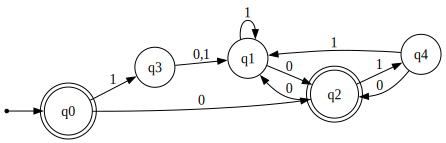

In [21]:
ex1 = DFA(
  states={'q0', 'q1', 'q2', 'q3', 'q4'},
  input_symbols={'0', '1'},
  transitions={
    'q0': {'0': 'q2', '1': 'q3'},
    'q1': {'0': 'q2', '1': 'q1'},
    'q2': {'0': 'q1', '1': 'q4'},
    'q3': {'0': 'q1', '1': 'q1'},
    'q4': {'0': 'q2', '1': 'q1'}
  },
  initial_state='q0',
  final_states={'q2', 'q0'},
)
ex1

Just for the sake of completeness, below is the minified (in the standard way) automaton.

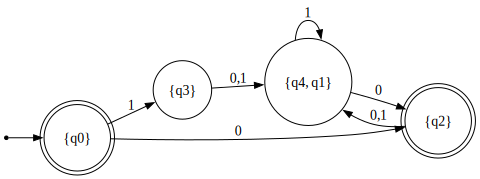

In [22]:
ex1.minify(retain_names=True)

Finally, below is the hyper-minimized automaton obtained using respectively the Badr-Geffert-Shipman, Badr and Holzer-Maletti algorithms.

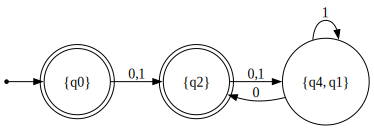

In [23]:
badr_geffert_shipman_hyper_minimize(ex1)

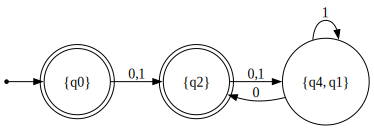

In [24]:
badr_hyper_minimize(ex1)

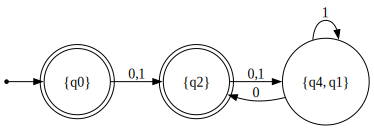

In [25]:
holzer_maletti_hyper_minimize(ex1)

##### Example 2

Here is another, more extended, example of DFA on which the hyper minimization will be performed. Please note that the automaton is already minimized in the standard way.

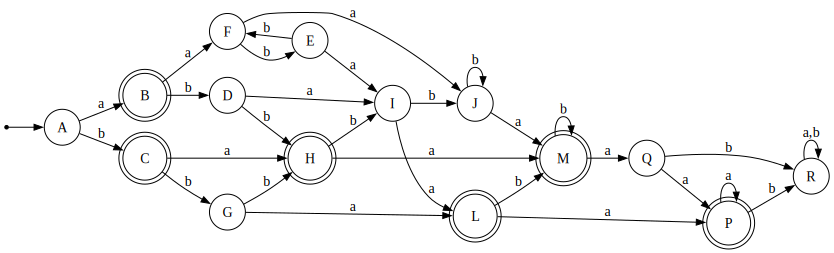

In [26]:
ex2 = DFA(
  states={'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'P', 'Q', 'R'},
  input_symbols={'a', 'b'},
  initial_state='A',
  final_states={'B', 'C', 'H', 'M', 'L', 'P'},
  transitions={
    'A': {'a': 'B', 'b': 'C'},
    'B': {'a': 'F', 'b': 'D'},
    'C': {'a': 'H', 'b': 'G'},
    'D': {'a': 'I', 'b': 'H'},
    'E': {'a': 'I', 'b': 'F'},
    'F': {'a': 'J', 'b': 'E'},
    'G': {'a': 'L', 'b': 'H'},
    'H': {'a': 'M', 'b': 'I'},
    'I': {'a': 'L', 'b': 'J'},
    'J': {'a': 'M', 'b': 'J'},
    'L': {'a': 'P', 'b': 'M'},
    'M': {'a': 'Q', 'b': 'M'},
    'P': {'a': 'P', 'b': 'R'},
    'Q': {'a': 'P', 'b': 'R'},
    'R': {'a': 'R', 'b': 'R'}
  }
)
ex2

Hyper-minimization is performed using the defined algorithms.

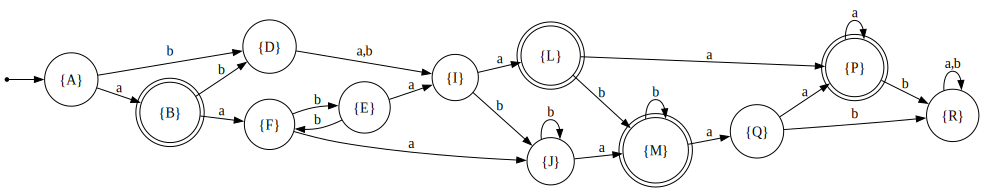

In [27]:
badr_geffert_shipman_hyper_minimize(ex2)

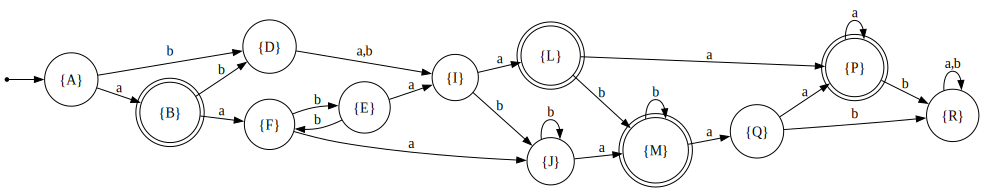

In [28]:
badr_hyper_minimize(ex2)

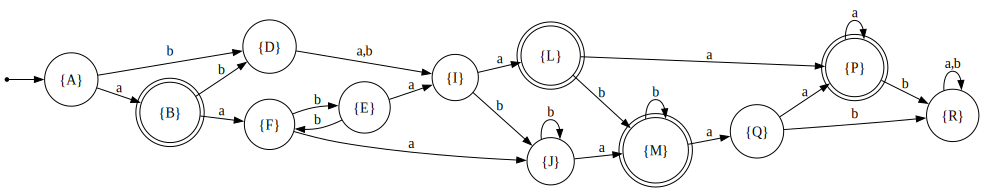

In [29]:
holzer_maletti_hyper_minimize(ex2)

##### Thesis example

Last but not least, the automaton used in the thesis is hyper-minimized using the implemented algorithms.

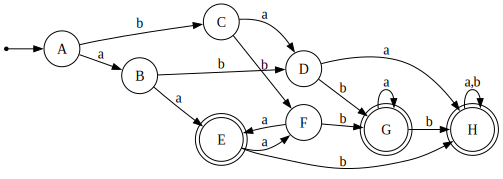

In [30]:
ex3 = DFA(
  states={'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'},
  input_symbols={'a', 'b'},
  initial_state='A',
  final_states={'E', 'G', 'H'},
  transitions={
    'A': {'a': 'B', 'b': 'C'},
    'B': {'a': 'E', 'b': 'D'},
    'C': {'a': 'D', 'b': 'F'},
    'D': {'a': 'H', 'b': 'G'},
    'E': {'a': 'F', 'b': 'H'},
    'F': {'a': 'E', 'b': 'G'},
    'G': {'a': 'G', 'b': 'H'},
    'H': {'a': 'H', 'b': 'H'}
  }
)
ex3

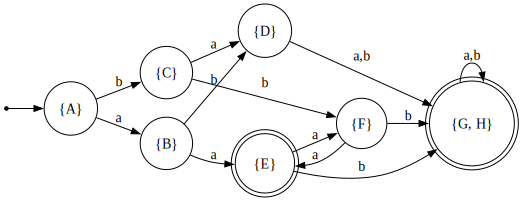

In [31]:
ex3.minify(retain_names=True)

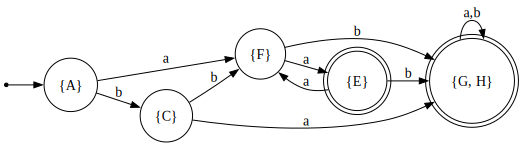

In [32]:
badr_geffert_shipman_hyper_minimize(ex3)

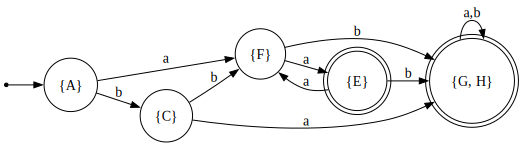

In [33]:
badr_hyper_minimize(ex3)

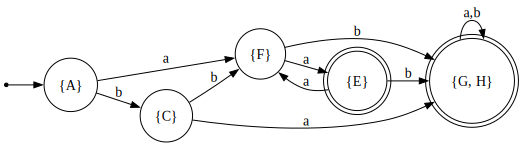

In [34]:
holzer_maletti_hyper_minimize(ex3)

##### Proof of correctness

Following the original paper, the correctness of the hyper-minimized automata is checked below.

More specifically:
_An automaton $M$ is hyper-minimized if and only if, in $M$:_
1. _there does not exist an unreachable state_
2. _there does not exist a pair of different but equivalent states_
3. _there does not exist a pair of different but almost-equivalent states, such that at least one of them is a preamble state_

Please note that the first two condition are satisfied if the automaton is already minimized in the standard way.

Here is defined an algorithm which verifies if a given automaton is hyper-minimized.

In [35]:
def is_hyper_minimal(dfa: DFA):
  """
  Checks if a DFA is hyper-minimal.
  """
  # check of the non-existence of unreachable states or couples of different but equivalent states
  minimal_dfa = dfa.minify(retain_names=True)
  if len(minimal_dfa.states) != len(dfa.states):
    return False
  
  # check of the non-existence of couples of different but almost-equivalent states using the strategy reported 
  # in the original paper with the use of the QuickUnion technique

  # first builds the partition of the states of the DFA into the almost-equivalence classes
  partition = QuickFind()
  for q in minimal_dfa.states: # initial partitioning of the states Q = {q_1} ∪ {q_2} ∪ ... ∪ {q_n}
    partition.make_set(q)
  states = list(minimal_dfa.states) # needed to slice the states list
  while True:
    # flag used to exit the loop if no almost-equivalent states are found
    ae_found = False

    # searches for couples of states q_i1 and q_i2, with i1 ≠ i2, that are not already in the same set of the partition P
    for i, q1 in enumerate(states):
      for q2 in states[i+1:]:
        P_q1, P_q2 = partition.find(q1), partition.find(q2)
        if P_q1 != P_q2:
          ae = True
          for sigma in minimal_dfa.input_symbols:
            if partition.find(minimal_dfa.transitions[q1][sigma]) != partition.find(minimal_dfa.transitions[q2][sigma]):
              ae = False
              break
          if ae:
            for q in states:
              P_q = partition.find(q)
              if P_q == P_q2:
                partition.union(P_q1, P_q2)
            ae_found = True

    # if no almost-equivalent states are found, the loop is exited
    if not ae_found:
      break

  preamble, _ = preamble_and_kernel(minimal_dfa) # badr algorithm

  return not any(len(preamble.intersection(s)) > 1 for s in partition.parts())

A quick validation of the results obtained by the three algorithms is provided.

In [36]:
(is_hyper_minimal(ex1), is_hyper_minimal(ex2), is_hyper_minimal(ex3))

(False, False, False)

In [37]:
print("Example 1", (is_hyper_minimal(badr_geffert_shipman_hyper_minimize(ex1)), is_hyper_minimal(badr_hyper_minimize(ex1)), is_hyper_minimal(holzer_maletti_hyper_minimize(ex1))))
print("Example 2", (is_hyper_minimal(badr_geffert_shipman_hyper_minimize(ex2)), is_hyper_minimal(badr_hyper_minimize(ex2)), is_hyper_minimal(holzer_maletti_hyper_minimize(ex2))))
print("Example 3", (is_hyper_minimal(badr_geffert_shipman_hyper_minimize(ex3)), is_hyper_minimal(badr_hyper_minimize(ex3)), is_hyper_minimal(holzer_maletti_hyper_minimize(ex3))))

Example 1 (True, True, True)
Example 2 (True, True, True)
Example 3 (True, True, True)


### Algorithms performance analysis

##### Graph params

In [38]:
color_palette = ['#d4fce9', '#96e4c1', '#48b89f', '#2d7d90', '#113b55', '#001f30', '#000000']

##### DFA generation

Below is defined an algorithm that generates a random DFA with an alphabet of fixed size 2 and $n$ states, more specifically, the generation can be fine tuned, other than the number of states, among the ratio of preamble and kernel states, the final states ratio in the kernel and the kernel composition (single or multiple SCCs).

In [39]:
def generate_preamble(dfa: IncrementalDFA, n: int):
  preamble_states_matrix = np.array([[f'p{i}.{j}' for j in range(n)] for i in range(n)])
  for i in range(n):
    for j in range(n):
      dfa.transitions[preamble_states_matrix[i][j]] = dict()
      if j < n-1:
        dfa.transitions[preamble_states_matrix[i][j]]['a'] = preamble_states_matrix[i][j+1]
      if i < n-1:
        dfa.transitions[preamble_states_matrix[i][j]]['b'] = preamble_states_matrix[i+1][j]

  return preamble_states_matrix.flatten().tolist()

In [40]:
def generate_kernel(dfa: IncrementalDFA, n: int, multiple_scc: bool):
  states = [f'k{i}' for i in range(n)]
  sccs = QuickFind()
  processed_states = set()

  # computes the strongly connected components of the kernel
  while len(processed_states) < n:
    scc_size = random.randint(1, n - len(processed_states)) if multiple_scc else n
    scc = random.sample(list(set(states) - processed_states), scc_size)
    
    sccs.make_set(scc[0])
    for i in range(1, scc_size):
      sccs.make_set(scc[i])
      sccs.union(sccs.find(scc[i-1]), sccs.find(scc[i]))
    
    processed_states = processed_states.union(set(scc))

  # computes the transitions between the states of each strongly connected component
  for scc in sccs.parts():
      scc_states = list(scc)
      for i in range(len(scc_states)):
        dfa.transitions[scc_states[i]] = dict()
        dfa.transitions[scc_states[i]]['a'] = scc_states[(i+1) % len(scc_states)]
        dfa.transitions[scc_states[i]]['b'] = random.choice(list(scc))

  # enforces the connection between different strongly connected components
  parts = sccs.partition()
  for i in range(len(parts)):
    for j in range(i+1, len(parts)):
      q_i = random.choice(list(parts[i]))
      q_j = random.choice(list(parts[j]))
      dfa.transitions[q_i]['b'] = q_j

  return states

In [41]:
def connect_preamble_kernel(dfa: IncrementalDFA, p_states: list, k_states: list):
  p_matrix_row_size = math.floor(math.sqrt(len(p_states)))
  p_matrix_bottom_row = p_states[-p_matrix_row_size:]
  p_matrix_right_col = [p_states[(p_matrix_row_size*i)-1] for i in range(1, p_matrix_row_size+1)]

  # all the preamble states on the states matrix bottom edge and right edge should be connected to the kernel
  # states, in particular, each state on the bottom edge should be connected using the transition of symbol 'b'
  # and each state on the right edge should be connected using the transition of symbol 'a' (except for the state
  # on the bottom right corner which should be connected using both transitions)
  k_conn_points = k_states.copy()
  if len(k_conn_points) < p_matrix_row_size*2:
    k_conn_points = (k_conn_points * math.ceil((p_matrix_row_size*2)/len(k_conn_points)))
  random.shuffle(k_conn_points)

  for q in p_matrix_bottom_row:
    dfa.transitions[q]['b'] = k_conn_points.pop()
  for q in p_matrix_right_col:
    dfa.transitions[q]['a'] = k_conn_points.pop()

In [42]:
def generate_dfa(num_of_states: int, p_states_ratio: float = 0.5, f_states_ratio: float = 0.5, multiple_scc=False) -> DFA:
  # initializes the DFA
  dfa = IncrementalDFA()
  dfa.input_symbols = {'a', 'b'}
  dfa.transitions = dict()

  # generates the preamble
  p_states = generate_preamble(dfa, math.floor(math.sqrt(num_of_states * p_states_ratio)))

  # generates the kernel
  k_states = generate_kernel(dfa, num_of_states - len(p_states), multiple_scc)

  # connects the preamble with the kernel
  connect_preamble_kernel(dfa, p_states, k_states)

  # dfa composition
  dfa.states = set(p_states + k_states)
  dfa.initial_state = p_states[0] if len(p_states) > 0 else random.choice(k_states)
  dfa.final_states = set(random.sample(k_states, math.floor(len(k_states) * f_states_ratio)))

  return dfa.build()

##### Fine tuning of the parameters of the DFA generation to maximize the hyper-minimization effectiveness

It is needed to verify the effectiveness of the hyper-minimization algorithms in different scenarios, so the parameters of the DFA generation are fine-tuned to maximize the hyper-minimization effectiveness.

**Effectiveness of the hyper-minimization on different number of states and final states ratios in the kernel**

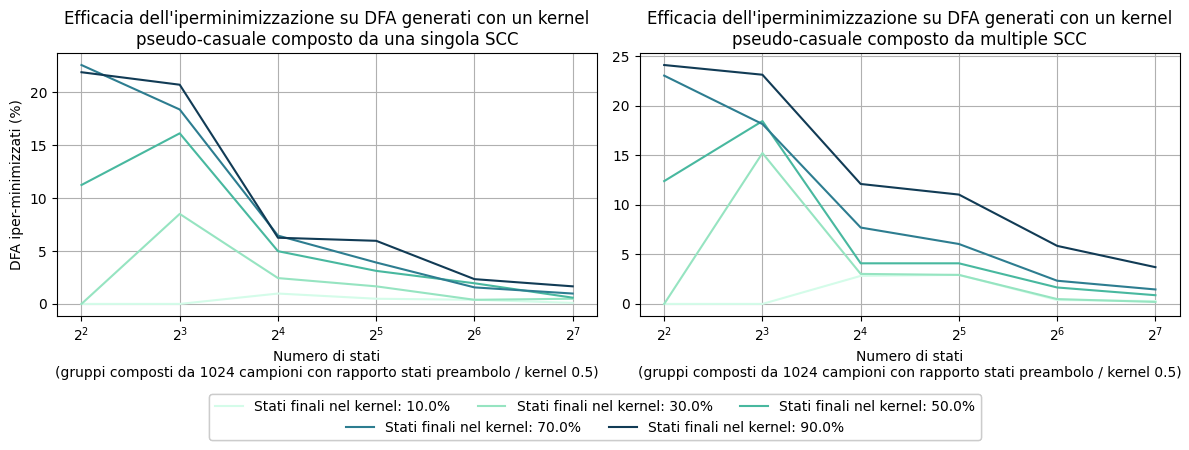

In [257]:
# fixed parameters: number of DFAs per ratio, percentage of preamble states
dfa_per_ratio, arg_p_states_ratio = 1024, 0.5
# varying parameters: percentage of final states in the kernel, number of states
f_states_ratios, states_count = np.linspace(0.1, 0.9, 5), [2**i for i in range(2, 8)]

sscc_data, mscc_data = dict(), dict() # single SCC data, multiple SCC data

for f_states_ratio in f_states_ratios: # variation of the f_states_ratio
  # initialization of the data structures
  sscc_data[f_states_ratio] = dict()
  mscc_data[f_states_ratio] = dict()

  # variation of the number of states
  for n in states_count:
    sscc_hyper_minimized, mscc_hyper_minimized = 0, 0

    # generation of automata to be hyper-minimized with the current f_states_ratio and number of states n
    for i in range(dfa_per_ratio):
      sscc_dfa = generate_dfa(n, arg_p_states_ratio, f_states_ratio, False) # base dfa with a single SCC
      mscc_dfa = generate_dfa(n, arg_p_states_ratio, f_states_ratio, True)  # base dfa with multiple SCCs
      
      # minimization to understand if the hyper-minimization further reduces the number of states
      minimal_sscc_dfa = sscc_dfa.minify(retain_names=True)
      minimal_mscc_dfa = mscc_dfa.minify(retain_names=True)

      # hyper-minimization
      hyper_minimal_sscc_dfa = holzer_maletti_hyper_minimize(minimal_sscc_dfa)
      hyper_minimal_mscc_dfa = holzer_maletti_hyper_minimize(minimal_mscc_dfa)

      # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
      if len(minimal_sscc_dfa.states) != len(hyper_minimal_sscc_dfa.states):
        sscc_hyper_minimized += 1
      if len(minimal_mscc_dfa.states) != len(hyper_minimal_mscc_dfa.states):
        mscc_hyper_minimized += 1
    
    # computes the percentage of hyper-minimized automata for the current f_states_ratio and number of states n
    # for both single and multiple SCCs
    sscc_data[f_states_ratio][n] = round((sscc_hyper_minimized / dfa_per_ratio) * 100, 2)
    mscc_data[f_states_ratio][n] = round((mscc_hyper_minimized / dfa_per_ratio) * 100, 2)

# plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
x_axis = [f'$2^{int(math.log2(n))}$' for n in states_count]

axs[0].set_title("Efficacia dell'iperminimizzazione su DFA generati con un kernel\npseudo-casuale composto da una singola SCC")
axs[0].set_xlabel(f'Numero di stati\n(gruppi composti da {dfa_per_ratio} campioni con rapporto stati preambolo / kernel {arg_p_states_ratio})')
axs[0].set_ylabel('DFA iper-minimizzati (%)')
axs[0].grid(True)

for i, f_states_ratio in enumerate(f_states_ratios):
  axs[0].plot(x_axis, list(sscc_data[f_states_ratio].values()), color=color_palette[i], label=f'Stati finali nel kernel: {round(f_states_ratio, 2) * 100}%')

axs[1].set_title("Efficacia dell'iperminimizzazione su DFA generati con un kernel\npseudo-casuale composto da multiple SCC")
axs[1].set_xlabel(f'Numero di stati\n(gruppi composti da {dfa_per_ratio} campioni con rapporto stati preambolo / kernel {arg_p_states_ratio})')
axs[1].grid(True)

for i, f_states_ratio in enumerate(f_states_ratios):
  axs[1].plot(x_axis, list(mscc_data[f_states_ratio].values()), color=color_palette[i], label=f'Stati finali nel kernel: {round(f_states_ratio, 2) * 100}%')

ncols, nlines = 3, 5
handles, labels = axs[0].get_legend_handles_labels() # same for each subplot
kw = dict(framealpha=1, bbox_to_anchor=(0.5, -0.13), loc="lower center", bbox_transform=fig.transFigure)
leg1 = fig.legend(handles=handles[:nlines//ncols*ncols], ncol=ncols, **kw)
fig.gca().add_artist(leg1)
leg2 = plt.legend(handles=handles[nlines//ncols*ncols:], ncol=nlines-nlines//ncols*ncols)
leg2.remove()
leg1._legend_box._children.append(leg2._legend_handle_box)
leg1._legend_box.stale = True

plt.tight_layout()

plt.show()

**Effectiveness of the hyper-minimization on different final states ratios in the kernel and different preamble/kernel states ratios**

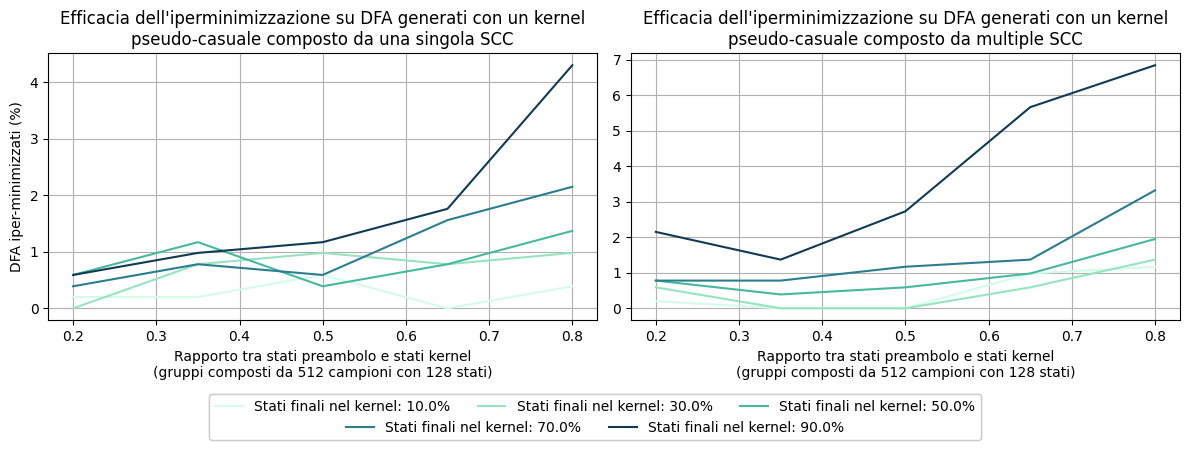

In [85]:
# fixed parameters: number of DFAs per ratio, number of states per DFA
dfa_per_ratio, arg_states_count = 512, 128
# varying parameters: percentage of preamble states, percentage of final states in the kernel
f_states_ratios, p_states_ratios = np.linspace(0.1, 0.9, 5), np.linspace(0.2, 0.8, 5)

sscc_data, mscc_data = dict(), dict() # single SCC data, multiple SCC data

for f_states_ratio in f_states_ratios: # variation of the f_states_ratio
  # initialization of the data structures
  sscc_data[f_states_ratio] = dict()
  mscc_data[f_states_ratio] = dict()

  for p_states_ratio in p_states_ratios: # variation of the p_states_ratio
    sscc_hyper_minimized, mscc_hyper_minimized = 0, 0

    # generation of automata with the current f_states_ratio and the current p_states_ratio
    for i in range(dfa_per_ratio):
      sscc_dfa = generate_dfa(arg_states_count, p_states_ratio, f_states_ratio, False) # base dfa with a single SCC
      mscc_dfa = generate_dfa(arg_states_count, p_states_ratio, f_states_ratio, True)  # base dfa with multiple SCCs
      
      # minimization to understand if the hyper-minimization further reduces the number of states
      minimal_sscc_dfa = sscc_dfa.minify(retain_names=True)
      minimal_mscc_dfa = mscc_dfa.minify(retain_names=True)

      # hyper-minimization
      hyper_minimal_sscc_dfa = holzer_maletti_hyper_minimize(minimal_sscc_dfa)
      hyper_minimal_mscc_dfa = holzer_maletti_hyper_minimize(minimal_mscc_dfa)

      # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
      if len(minimal_sscc_dfa.states) != len(hyper_minimal_sscc_dfa.states):
        sscc_hyper_minimized += 1
      if len(minimal_mscc_dfa.states) != len(hyper_minimal_mscc_dfa.states):
        mscc_hyper_minimized += 1
    
    # computes the percentage of hyper-minimized automata for the current f_states_ratio and p_states_ratio
    # for both single and multiple SCCs
    sscc_data[f_states_ratio][p_states_ratio] = round((sscc_hyper_minimized / dfa_per_ratio) * 100, 2)
    mscc_data[f_states_ratio][p_states_ratio] = round((mscc_hyper_minimized / dfa_per_ratio) * 100, 2)

# plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
x_axis = [round(states_ratio, 2) for states_ratio in p_states_ratios]

axs[0].set_title("Efficacia dell'iperminimizzazione su DFA generati con un kernel\npseudo-casuale composto da una singola SCC")
axs[0].set_xlabel(f'Rapporto tra stati preambolo e stati kernel\n(gruppi composti da {dfa_per_ratio} campioni con {arg_states_count} stati)')
axs[0].set_ylabel('DFA iper-minimizzati (%)')
axs[0].grid(True)

for i, f_states_ratio in enumerate(f_states_ratios):
  axs[0].plot(x_axis, list(sscc_data[f_states_ratio].values()), color=color_palette[i], label=f'Stati finali nel kernel: {round(f_states_ratio, 2) * 100}%')

axs[1].set_title("Efficacia dell'iperminimizzazione su DFA generati con un kernel\npseudo-casuale composto da multiple SCC")
axs[1].set_xlabel(f'Rapporto tra stati preambolo e stati kernel\n(gruppi composti da {dfa_per_ratio} campioni con {arg_states_count} stati)')
axs[1].grid(True)

for i, f_states_ratio in enumerate(f_states_ratios):
  axs[1].plot(x_axis, list(mscc_data[f_states_ratio].values()), color=color_palette[i], label=f'Stati finali nel kernel: {round(f_states_ratio, 2) * 100}%')

ncols, nlines = 3, 5
handles, labels = axs[0].get_legend_handles_labels() # same for each subplot
kw = dict(framealpha=1, bbox_to_anchor=(0.5, -0.13), loc="lower center", bbox_transform=fig.transFigure)
leg1 = fig.legend(handles=handles[:nlines//ncols*ncols], ncol=ncols, **kw)
fig.gca().add_artist(leg1)
leg2 = plt.legend(handles=handles[nlines//ncols*ncols:], ncol=nlines-nlines//ncols*ncols)
leg2.remove()
leg1._legend_box._children.append(leg2._legend_handle_box)
leg1._legend_box.stale = True

plt.tight_layout()

plt.show()

Results indicates that the hyper-minimization is more effective in automata with a randomly-generated kernel composed by multiple SCCs where there is a higher ratio of preamble states and a higher ratio of final states in the kernel, in other words, the hyper-minimization is more effective in automata with a kernel of reduced size and with the majority of the states in the kernel.

**Effectiveness of the hyper-minimization on different number of states, different preamble/kernel states ratios and fixed high final states ratio**

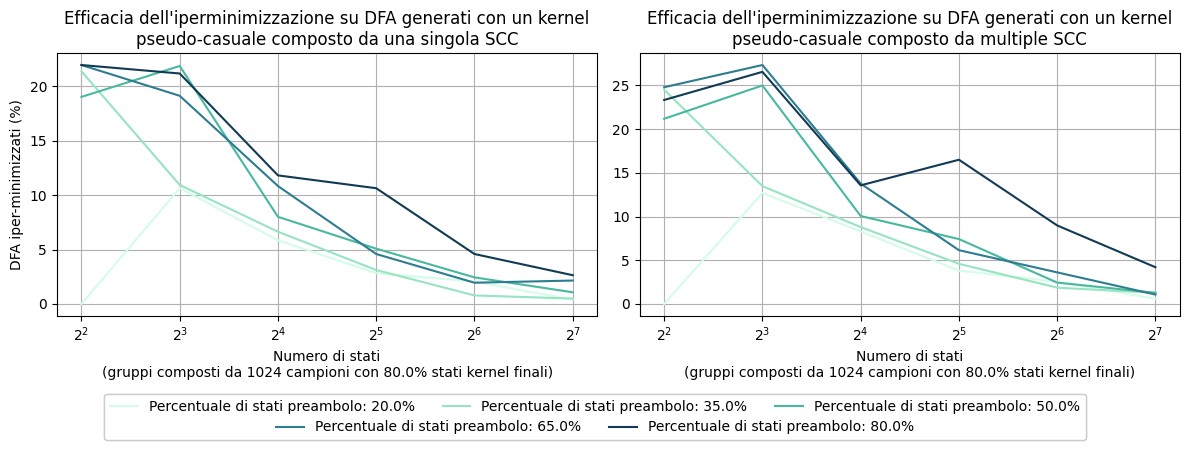

In [86]:
# fixed parameters: number of DFAs per ratio, number of states per DFA
dfa_per_ratio, arg_f_states_ratios = 1024, 0.8
# varying parameters: number of states, percentage of preamble states
states_count, p_states_ratios = [2**i for i in range(2, 8)], np.linspace(0.2, 0.8, 5)

sscc_data, mscc_data = dict(), dict() # single SCC data, multiple SCC data

for p_states_ratio in p_states_ratios: # variation of the p_states_ratio
  # initialization of the data structures
  sscc_data[p_states_ratio] = dict()
  mscc_data[p_states_ratio] = dict()

  # variation of the number of states
  for n in states_count:
    sscc_hyper_minimized, mscc_hyper_minimized = 0, 0

    # generation of automata with the current f_states_ratio and the current p_states_ratio
    for i in range(dfa_per_ratio):
      sscc_dfa = generate_dfa(n, p_states_ratio, arg_f_states_ratios, False) # base dfa with a single SCC
      mscc_dfa = generate_dfa(n, p_states_ratio, arg_f_states_ratios, True)  # base dfa with multiple SCCs
      
      # minimization to understand if the hyper-minimization further reduces the number of states
      minimal_sscc_dfa = sscc_dfa.minify(retain_names=True)
      minimal_mscc_dfa = mscc_dfa.minify(retain_names=True)

      # hyper-minimization
      hyper_minimal_sscc_dfa = holzer_maletti_hyper_minimize(minimal_sscc_dfa)
      hyper_minimal_mscc_dfa = holzer_maletti_hyper_minimize(minimal_mscc_dfa)

      # checks if the hyper-minimal DFA is more minimal than the standard-way minimized DFA
      if len(minimal_sscc_dfa.states) != len(hyper_minimal_sscc_dfa.states):
        sscc_hyper_minimized += 1
      if len(minimal_mscc_dfa.states) != len(hyper_minimal_mscc_dfa.states):
        mscc_hyper_minimized += 1
    
    # computes the percentage of hyper-minimized automata for the current p_states_ratio and number of states n
    # for both single and multiple SCCs
    sscc_data[p_states_ratio][n] = round((sscc_hyper_minimized / dfa_per_ratio) * 100, 2)
    mscc_data[p_states_ratio][n] = round((mscc_hyper_minimized / dfa_per_ratio) * 100, 2)

# plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
x_axis = [f'$2^{int(math.log2(n))}$' for n in states_count]

axs[0].set_title("Efficacia dell'iperminimizzazione su DFA generati con un kernel\npseudo-casuale composto da una singola SCC")
axs[0].set_xlabel(f'Numero di stati\n(gruppi composti da {dfa_per_ratio} campioni con {round(arg_f_states_ratios, 2) * 100}% stati kernel finali)')
axs[0].set_ylabel('DFA iper-minimizzati (%)')
axs[0].grid(True)

for i, p_states_ratio in enumerate(p_states_ratios):
  axs[0].plot(x_axis, list(sscc_data[p_states_ratio].values()), color=color_palette[i], label=f'Percentuale di stati preambolo: {round(p_states_ratio, 2) * 100}%')

axs[1].set_title("Efficacia dell'iperminimizzazione su DFA generati con un kernel\npseudo-casuale composto da multiple SCC")
axs[1].set_xlabel(f'Numero di stati\n(gruppi composti da {dfa_per_ratio} campioni con {round(arg_f_states_ratios, 2) * 100}% stati kernel finali)')
axs[1].grid(True)

for i, p_states_ratio in enumerate(p_states_ratios):
  axs[1].plot(x_axis, list(mscc_data[p_states_ratio].values()), color=color_palette[i], label=f'Percentuale di stati preambolo: {round(p_states_ratio, 2) * 100}%')

ncols, nlines = 3, 5
handles, labels = axs[0].get_legend_handles_labels() # same for each subplot
kw = dict(framealpha=1, bbox_to_anchor=(0.5, -0.13), loc="lower center", bbox_transform=fig.transFigure)
leg1 = fig.legend(handles=handles[:nlines//ncols*ncols], ncol=ncols, **kw)
fig.gca().add_artist(leg1)
leg2 = plt.legend(handles=handles[nlines//ncols*ncols:], ncol=nlines-nlines//ncols*ncols)
leg2.remove()
leg1._legend_box._children.append(leg2._legend_handle_box)
leg1._legend_box.stale = True

plt.tight_layout()

plt.show()

Results shows that indipendently from the kernel composition, the hyper-minimization is more effective in automata with a lower number of states and an higher ratio of preamble/kernel states, in other words, automata with a kernel of reduced size and high preamble/kernel ratio (considering an high final states ratio in the kernel) are more likely to be hyper-minimized.

##### Experimental results

Following the previous dfa-generation analysis, below are defined the parameters used to generate the automata for the performance analysis.

In [62]:
num_of_states   = [2**exp for exp in range(1, 11)]  # automaton states
group_size      = 256                               # number of automata per size
p_states_ratio  = 0.8                               # kernels of reduced size
f_states_ratio  = 0.8                               # high final kernel states
multiple_scc    = True                              # multiple SCCs kernel composition


A test suite generator function is defined, this function generates a list (group) of test cases (DFAs with fixed number of states depending on the group).

In [63]:
def generate_test_suite(tests_per_group = 100) -> list[list[DFA]]:
  """
  Generate a test suite divided into groups of test automata with equal number of states for the hyper-minimization algorithms.
  """
  return [[generate_dfa(n, p_states_ratio, f_states_ratio, multiple_scc) for _ in range(tests_per_group)] for n in num_of_states]

A test-runner function is defined, this function runs the given hyper-minimization algorithm on the given test cases and saves the results in a `.csv` file.

The progress of the execution is printed as output along with the name of the file where the report is saved.

In [64]:
def run_tests(suite: list[list[DFA]], algorithm: callable):
  """
  Run a test suite of DFAs using a given algorithm and stores the results in a CSV file.
  """
  with open(algorithm.__name__ + '.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Test Group', 'Test Number', 'Initial Number of States', 'Minimal Number of States', 'Hyper-Minimal Number of States', 'Hyper-Minimal Check', 'Elapsed Time (s)'])

    # iterate over each group of tests
    for i, group in enumerate(suite):
      # iterate over each test in the current group
      for j, dfa in enumerate(group):
        # logs the running test
        print(f"Running test {i + 1}.{j + 1}.", end="\r")

        initial_states = len(dfa.states)            # initial number of states
        minimal_states = len(dfa.minify().states)   # number of states in the minimal DFA
        hm_dfa: DFA = None                          # hyper-minimal DFA
  
        def _exec():
          nonlocal hm_dfa
          hm_dfa = algorithm(dfa)

        time = timeit.timeit(_exec, number=1)
        hm_states = len(hm_dfa.states)
        hm_check = is_hyper_minimal(hm_dfa)

        csvwriter.writerow([i, j, initial_states, minimal_states, hm_states, hm_check, time])

      # logs the end of the group of tests
      print("Test suite", i + 1, "completed.")
    
    # logs the end
    print("Test suite completed, results at \"" + algorithm.__name__ + ".csv\"")

Following a test suite is generated and the tests are executed using the Badr-Geffert-Shipman, Badr and Holzer-Maletti algorithms.

In [65]:
test_suite = generate_test_suite(group_size)

In [136]:
run_tests(test_suite, badr_geffert_shipman_hyper_minimize)

Test suite 1 completed.
Test suite 2 completed.
Test suite 3 completed.
Test suite 4 completed.
Test suite 5 completed.
Test suite 6 completed.
Test suite 7 completed.
Test suite 8 completed.
Test suite 9 completed.
Test suite 10 completed.
Test suite completed, results at "badr_geffert_shipman_hyper_minimize.csv"


In [68]:
run_tests(test_suite, badr_hyper_minimize)

Test suite 1 completed.
Test suite 2 completed.
Test suite 3 completed.
Test suite 4 completed.
Test suite 5 completed.
Test suite 6 completed.
Test suite 7 completed.
Test suite 8 completed.
Test suite 9 completed.
Test suite 10 completed.
Test suite completed, results at "badr_hyper_minimize.csv"


In [66]:
run_tests(test_suite, holzer_maletti_hyper_minimize)

Test suite 1 completed.
Test suite 2 completed.
Test suite 3 completed.
Test suite 4 completed.
Test suite 5 completed.
Test suite 6 completed.
Test suite 7 completed.
Test suite 8 completed.
Test suite 9 completed.
Test suite 10 completed.
Test suite completed, results at "holzer_maletti_hyper_minimize.csv"


Results are now loaded into the notebook.

In [137]:
bgs_data  = pd.read_csv('badr_geffert_shipman_hyper_minimize.csv')
badr_data = pd.read_csv('badr_hyper_minimize.csv')
hm_data   = pd.read_csv('holzer_maletti_hyper_minimize.csv')

The first analysis is about the time taken by the algorithms to hyper-minimize the automata.

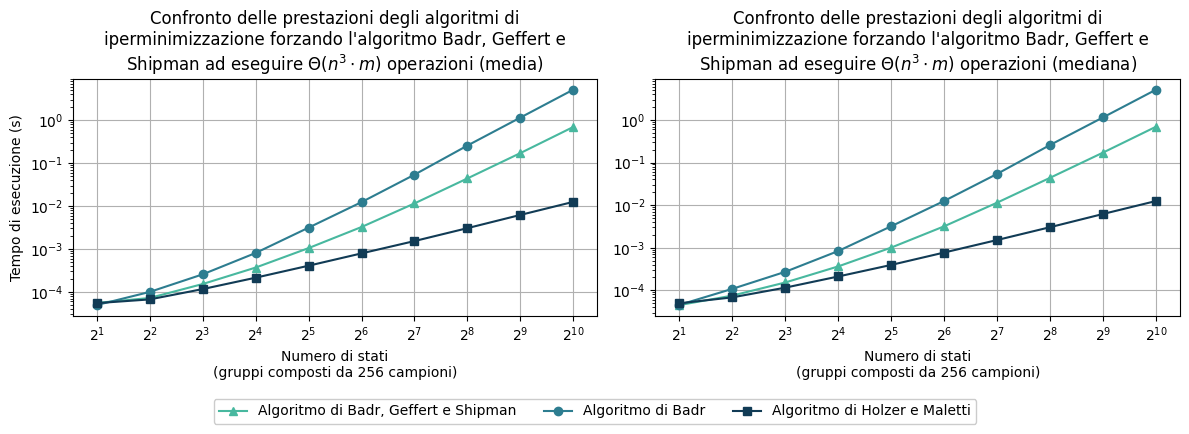

In [138]:
# mean time for each group of tests and each algorithm
bgs_mean  = bgs_data[['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').mean()
badr_mean = badr_data[['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').mean()
hm_mean   = hm_data[['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').mean()

# median time for each group of tests and each algorithm
bgs_median  = bgs_data[['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').median()
badr_median = badr_data[['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').median()
hm_median   = hm_data[['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').median()

# plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
x_labels = ['$2^{' + str(int(math.log2(n))) + '}$' for n in num_of_states]

axs[0].set_title("Confronto delle prestazioni degli algoritmi di\niperminimizzazione forzando l'algoritmo Badr, Geffert e\nShipman ad eseguire $\\Theta(n^3 \\cdot m)$ operazioni (media)")
axs[0].set_xlabel(f'Numero di stati\n(gruppi composti da {group_size} campioni)')
axs[0].set_ylabel('Tempo di esecuzione (s)')
axs[0].grid(True)
axs[0].set_yscale('log')
axs[0].plot(x_labels, bgs_mean, label='Algoritmo di Badr, Geffert e Shipman', color=color_palette[(len(color_palette)//2)-1], marker='^')
axs[0].plot(x_labels, badr_mean, label='Algoritmo di Badr', color=color_palette[(len(color_palette)//2)], marker='o')
axs[0].plot(x_labels, hm_mean, label='Algoritmo di Holzer e Maletti', color=color_palette[(len(color_palette)//2)+1], marker='s')

axs[1].set_title("Confronto delle prestazioni degli algoritmi di\niperminimizzazione forzando l'algoritmo Badr, Geffert e\nShipman ad eseguire $\\Theta(n^3 \\cdot m)$ operazioni (mediana)")
axs[1].set_xlabel(f'Numero di stati\n(gruppi composti da {group_size} campioni)')
axs[1].grid(True)
axs[1].set_yscale('log')
axs[1].plot(x_labels, bgs_median, label='Algoritmo di Badr, Geffert e Shipman', color=color_palette[(len(color_palette)//2)-1], marker='^')
axs[1].plot(x_labels, badr_median, label='Algoritmo di Badr', color=color_palette[(len(color_palette)//2)], marker='o')
axs[1].plot(x_labels, hm_median, label='Algoritmo di Holzer e Maletti', color=color_palette[(len(color_palette)//2)+1], marker='s')

ncols, nlines = 3, 3
handles, labels = axs[0].get_legend_handles_labels() # same for each subplot
kw = dict(framealpha=1, bbox_to_anchor=(0.5, -0.09), loc="lower center", bbox_transform=fig.transFigure)
leg1 = fig.legend(handles=handles, ncol=ncols, **kw)

plt.tight_layout()

plt.show()

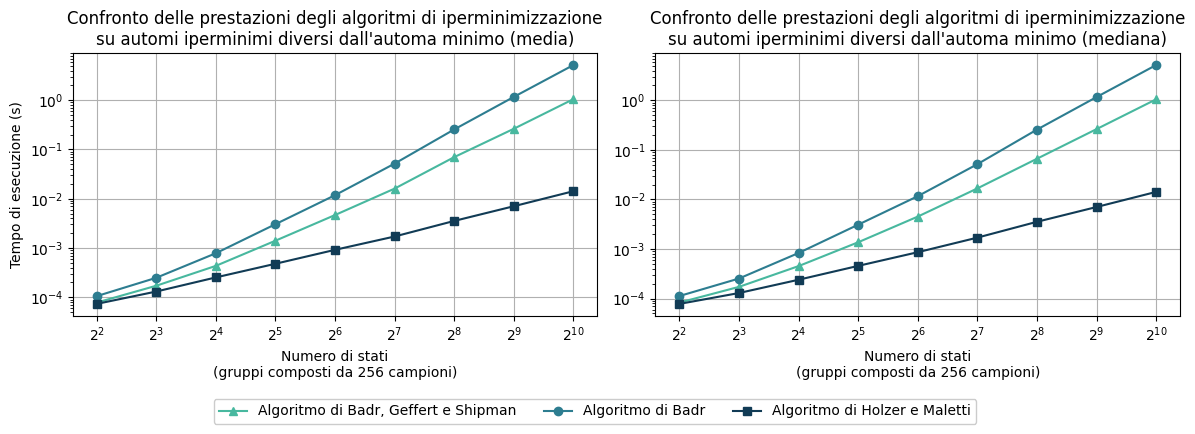

In [139]:
# mean time for hyper-minimized automaton which differs from the minimized one for each group of tests and each algorithm
hm_bgs_mean   = bgs_data[bgs_data['Minimal Number of States'] > bgs_data['Hyper-Minimal Number of States']][['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').mean()
hm_badr_mean  = badr_data[badr_data['Minimal Number of States'] > badr_data['Hyper-Minimal Number of States']][['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').mean()
hm_hm_mean    = hm_data[hm_data['Minimal Number of States'] > hm_data['Hyper-Minimal Number of States']][['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').mean()

# median time for hyper-minimized automaton which differs from the minimized one for each group of tests and each algorithm
hm_bgs_median   = bgs_data[bgs_data['Minimal Number of States'] > bgs_data['Hyper-Minimal Number of States']][['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').median()
hm_badr_median  = badr_data[badr_data['Minimal Number of States'] > badr_data['Hyper-Minimal Number of States']][['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').median()
hm_hm_median    = hm_data[hm_data['Minimal Number of States'] > hm_data['Hyper-Minimal Number of States']][['Initial Number of States', 'Elapsed Time (s)']].groupby('Initial Number of States').median()

# plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
x_labels = ['$2^{' + str(int(math.log2(n))) + '}$' for n in hm_hm_mean.index]

axs[0].set_title("Confronto delle prestazioni degli algoritmi di iperminimizzazione\nsu automi iperminimi diversi dall'automa minimo (media)")
axs[0].set_xlabel(f'Numero di stati\n(gruppi composti da {group_size} campioni)')
axs[0].set_ylabel('Tempo di esecuzione (s)')
axs[0].grid(True)
axs[0].set_yscale('log')
axs[0].plot(x_labels, hm_bgs_mean, label='Algoritmo di Badr, Geffert e Shipman', color=color_palette[(len(color_palette)//2)-1], marker='^')
axs[0].plot(x_labels, hm_badr_mean, label='Algoritmo di Badr', color=color_palette[(len(color_palette)//2)], marker='o')
axs[0].plot(x_labels, hm_hm_mean, label='Algoritmo di Holzer e Maletti', color=color_palette[(len(color_palette)//2)+1], marker='s')

axs[1].set_title("Confronto delle prestazioni degli algoritmi di iperminimizzazione\nsu automi iperminimi diversi dall'automa minimo (mediana)")
axs[1].set_xlabel(f'Numero di stati\n(gruppi composti da {group_size} campioni)')
axs[1].grid(True)
axs[1].set_yscale('log')
axs[1].plot(x_labels, hm_bgs_median, label='Algoritmo di Badr, Geffert e Shipman', color=color_palette[(len(color_palette)//2)-1], marker='^')
axs[1].plot(x_labels, hm_badr_median, label='Algoritmo di Badr', color=color_palette[(len(color_palette)//2)], marker='o')
axs[1].plot(x_labels, hm_hm_median, label='Algoritmo di Holzer e Maletti', color=color_palette[(len(color_palette)//2)+1], marker='s')

ncols, nlines = 3, 3
handles, labels = axs[0].get_legend_handles_labels() # same for each subplot
kw = dict(framealpha=1, bbox_to_anchor=(0.5, -0.09), loc="lower center", bbox_transform=fig.transFigure)
leg1 = fig.legend(handles=handles, ncol=ncols, **kw)

plt.tight_layout()

plt.show()

A more detailed plot, always about the time taken by the algorithms to hyper-minimize the automata, is provided.

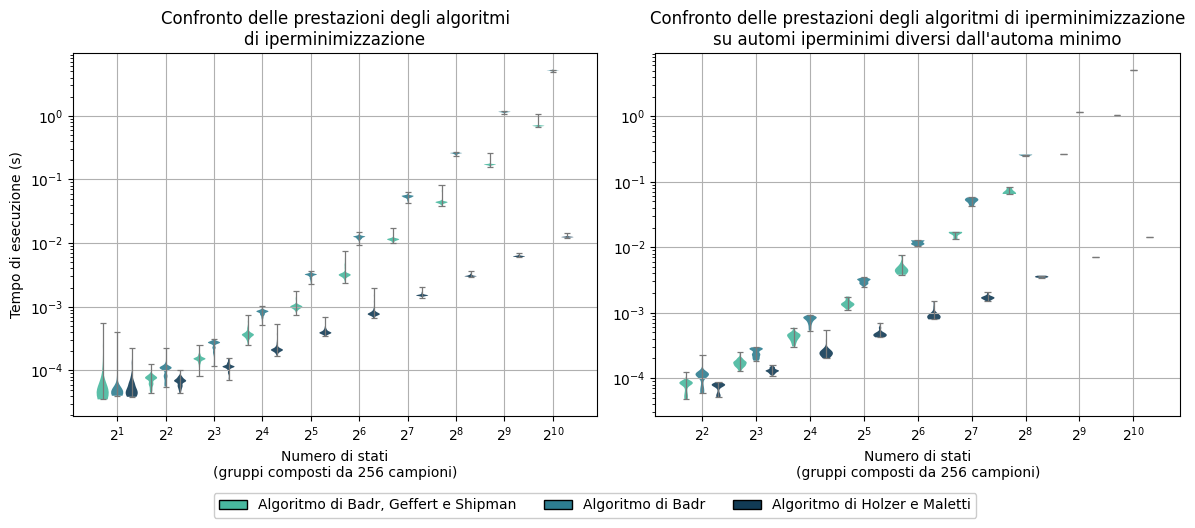

In [305]:
# extracts from the DataFrame the data to be plotted
all_data = lambda df: [df[df['Test Group'] == i]['Elapsed Time (s)'].values for i in df['Test Group'].unique()]
only_hm_data = lambda df: [df[(df['Test Group'] == i) & (df['Minimal Number of States'] > df['Hyper-Minimal Number of States'])]['Elapsed Time (s)'].values for i in df['Test Group'].unique()]

# plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plots = list()

plot_0_data = [all_data(bgs_data), all_data(badr_data), all_data(hm_data)]
x_labels_0 = ['$2^{' + str(int(math.log2(n))) + '}$' for n in num_of_states]
pos_0 = np.arange(1, len(test_suite)+1)

axs[0].set_title("Confronto delle prestazioni degli algoritmi\ndi iperminimizzazione")
axs[0].set_ylabel('Tempo di esecuzione (s)')
axs[0].grid(True)
axs[0].set_yscale('log')
axs[0].set_xticks(labels=x_labels_0, ticks=pos_0)
axs[0].set_xlabel(f'Numero di stati\n(gruppi composti da {group_size} campioni)')
plots.append(axs[0].violinplot(plot_0_data[0], positions=pos_0 - 0.3, showextrema=True, widths=0.25))
plots.append(axs[0].violinplot(plot_0_data[1], positions=pos_0, showextrema=True, widths=0.25))
plots.append(axs[0].violinplot(plot_0_data[2], positions=pos_0 + 0.3, showextrema=True, widths=0.25))

plot_1_data = [only_hm_data(bgs_data), only_hm_data(badr_data), only_hm_data(hm_data)]
x_labels_1 = ['$2^{' + str(x+1) + '}$' for x in range(len(plot_1_data[0])) if len(plot_1_data[0][x]) > 0]
pos_1 = np.arange(1, len(x_labels_1)+1)

axs[1].set_title("Confronto delle prestazioni degli algoritmi di iperminimizzazione\nsu automi iperminimi diversi dall'automa minimo")
axs[1].grid(True)
axs[1].set_yscale('log')
axs[1].set_xlabel(f'Numero di stati\n(gruppi composti da {group_size} campioni)')
axs[1].set_xticks(labels=x_labels_1, ticks=pos_1)
plots.append(axs[1].violinplot([x for x in plot_1_data[0] if len(x) > 0], positions=pos_1 - 0.3, showextrema=True, widths=0.25))
plots.append(axs[1].violinplot([x for x in plot_1_data[1] if len(x) > 0], positions=pos_1, showextrema=True, widths=0.25))
plots.append(axs[1].violinplot([x for x in plot_1_data[2] if len(x) > 0], positions=pos_1 + 0.3, showextrema=True, widths=0.25))

# violins appearance customization
for i, plot in enumerate(plots):
  for body in plot['bodies']:
    body.set_facecolor(color_palette[(len(color_palette)//2)-1+(i%3)])
    body.set_alpha(0.9)
  for partname in ('cbars','cmins','cmaxes'):
    vp = plot[partname]
    vp.set_edgecolor("#787878")
    vp.set_linewidth(0.9)

ncols, nlines = 3, 3
handles = [Patch(facecolor=color_palette[(len(color_palette)//2)-1+i], edgecolor='black', label=algo) for i, algo in enumerate(['Algoritmo di Badr, Geffert e Shipman', 'Algoritmo di Badr', 'Algoritmo di Holzer e Maletti'])]
kw = dict(framealpha=1, bbox_to_anchor=(0.5, -0.06), loc="lower center", bbox_transform=fig.transFigure)
leg1 = fig.legend(handles=handles, ncol=ncols, **kw)

plt.tight_layout()

plt.show()

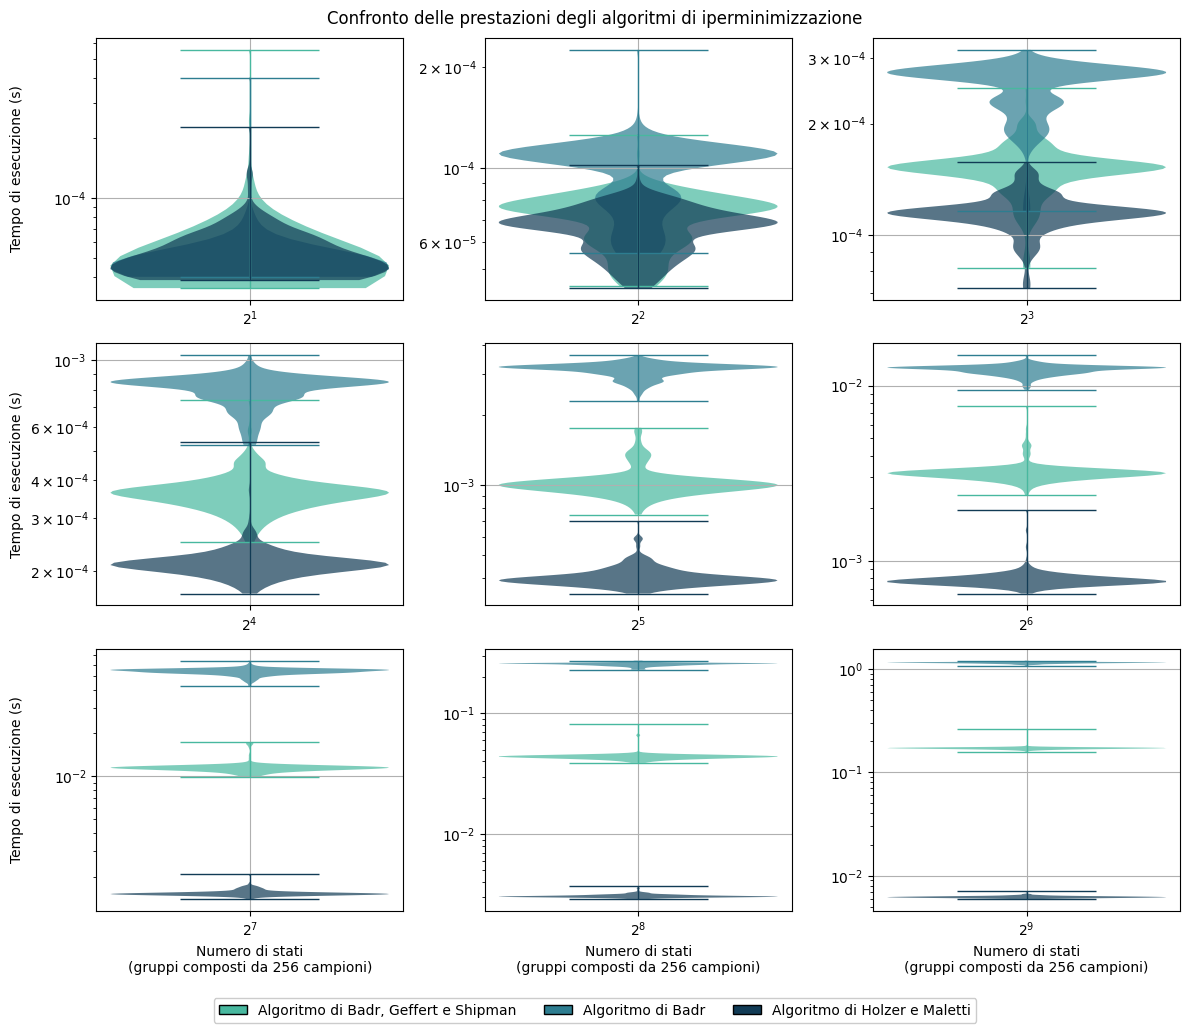

In [296]:
# plotting
fig, axs = plt.subplots(3, 3, figsize=(12, 10))
plots = list()

pos = np.arange(1, 2)

for i in range(9):
  row, col = i // 3, i % 3
  if col == 0:
    axs[row][col].set_ylabel('Tempo di esecuzione (s)')
  if row == 2:
    axs[row][col].set_xlabel(f'Numero di stati\n(gruppi composti da {group_size} campioni)')
  axs[row][col].grid(True)
  axs[row][col].set_yscale('log')
  axs[row][col].set_xticks(labels=x_labels_0[i:i+1], ticks=pos)
  plots.append(axs[row][col].violinplot(plot_0_data[0][i], positions=pos, showextrema=True, widths=0.25))
  plots.append(axs[row][col].violinplot(plot_0_data[1][i], positions=pos, showextrema=True, widths=0.25))
  plots.append(axs[row][col].violinplot(plot_0_data[2][i], positions=pos, showextrema=True, widths=0.25))

# violins appearance customization
for i, plot in enumerate(plots):
  for body in plot['bodies']:
    body.set_facecolor(color_palette[(len(color_palette)//2)-1+(i%3)])
    body.set_alpha(0.7)
  for partname in ('cbars','cmins','cmaxes'):
    vp = plot[partname]
    vp.set_edgecolor(color_palette[(len(color_palette)//2)-1+(i%3)])
    vp.set_linewidth(1)

ncols, nlines = 3, 3
handles = [Patch(facecolor=color_palette[(len(color_palette)//2)-1+i], edgecolor='black', label=algo) for i, algo in enumerate(['Algoritmo di Badr, Geffert e Shipman', 'Algoritmo di Badr', 'Algoritmo di Holzer e Maletti'])]
kw = dict(framealpha=1, bbox_to_anchor=(0.5, -0.04), loc="lower center", bbox_transform=fig.transFigure)
leg1 = fig.legend(handles=handles, ncol=ncols, **kw)

fig.align_ylabels(axs[:, 0])
fig.suptitle('Confronto delle prestazioni degli algoritmi di iperminimizzazione')
plt.tight_layout()

plt.show()

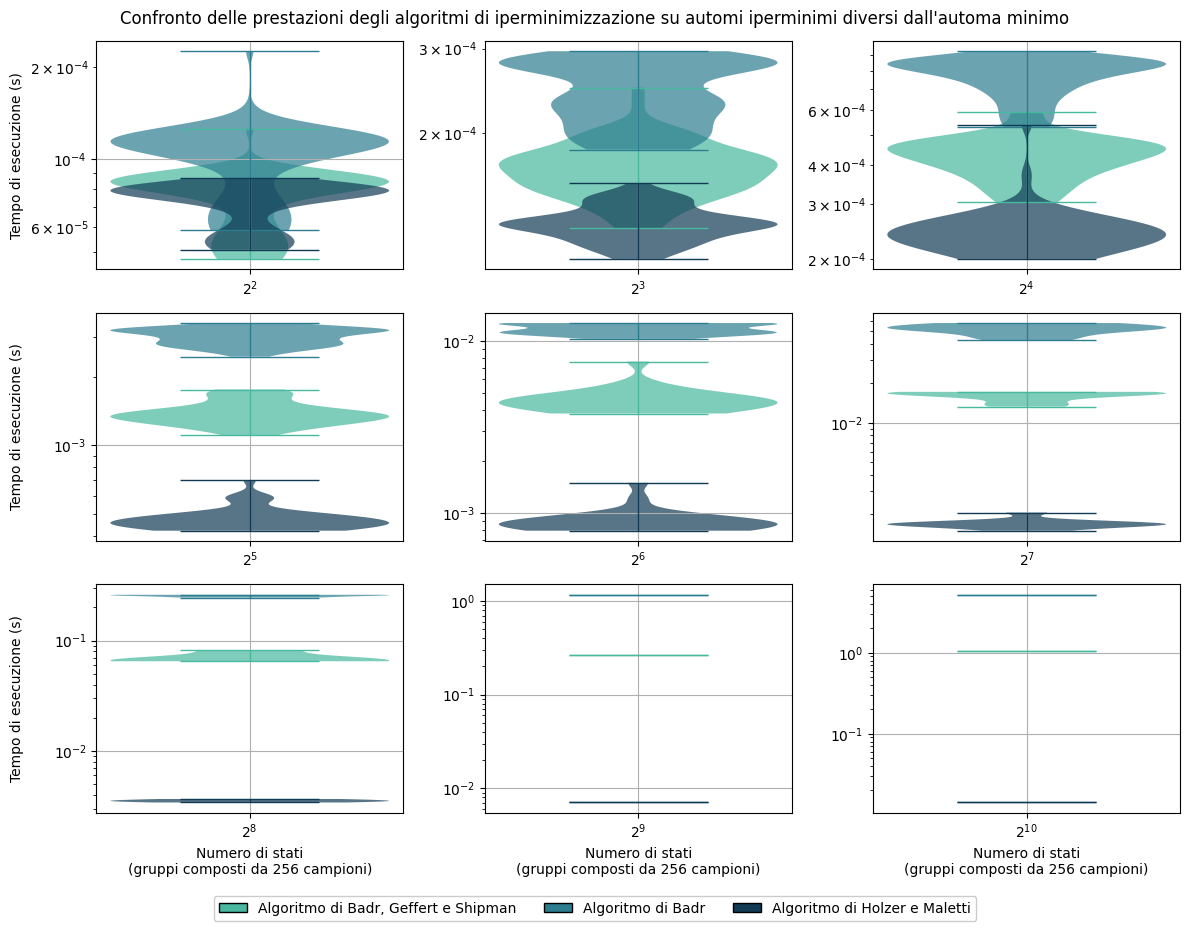

In [299]:
# plotting
fig, axs = plt.subplots(3, 3, figsize=(12, 9))
plots = list()

pos = np.arange(1, 2)

for i in range(9):
  row, col = i // 3, i % 3
  #axs[row][col].set_title("Confronto delle prestazioni degli algoritmi\ndi iperminimizzazione")
  if col == 0:
    axs[row][col].set_ylabel('Tempo di esecuzione (s)')
  if row == 2:
    axs[row][col].set_xlabel(f'Numero di stati\n(gruppi composti da {group_size} campioni)')
  axs[row][col].grid(True)
  axs[row][col].set_yscale('log')
  axs[row][col].set_xticks(labels=x_labels_1[i:i+1], ticks=pos)
  plots.append(axs[row][col].violinplot([x for x in plot_1_data[0] if len(x) > 0][i], positions=pos, showextrema=True, widths=0.25))
  plots.append(axs[row][col].violinplot([x for x in plot_1_data[1] if len(x) > 0][i], positions=pos, showextrema=True, widths=0.25))
  plots.append(axs[row][col].violinplot([x for x in plot_1_data[2] if len(x) > 0][i], positions=pos, showextrema=True, widths=0.25))

# violins appearance customization
for i, plot in enumerate(plots):
  for body in plot['bodies']:
    body.set_facecolor(color_palette[(len(color_palette)//2)-1+(i%3)])
    body.set_alpha(0.7)
  for partname in ('cbars','cmins','cmaxes'):
    vp = plot[partname]
    vp.set_edgecolor(color_palette[(len(color_palette)//2)-1+(i%3)])
    vp.set_linewidth(1)

ncols, nlines = 3, 3
handles = [Patch(facecolor=color_palette[(len(color_palette)//2)-1+i], edgecolor='black', label=algo) for i, algo in enumerate(['Algoritmo di Badr, Geffert e Shipman', 'Algoritmo di Badr', 'Algoritmo di Holzer e Maletti'])]
kw = dict(framealpha=1, bbox_to_anchor=(0.5, -0.04), loc="lower center", bbox_transform=fig.transFigure)
leg1 = fig.legend(handles=handles, ncol=ncols, **kw)

fig.align_ylabels(axs[:, 0])
fig.suptitle("Confronto delle prestazioni degli algoritmi di iperminimizzazione su automi iperminimi diversi dall'automa minimo")
plt.tight_layout()

plt.show()

##### Performance profiling

A more in-depth analysis on how the 3 algorithms spend their time is provided below using the `pyinstrument` library and generating a `speedscope` profile that can be visualized [here](https://www.speedscope.app/).

The tools are run on the biggest automaton generated in the previous test suite that can be hyper-minimized by the 3 algorithms.

In [122]:
biggest_automaton = hm_data[hm_data['Minimal Number of States'] != hm_data['Hyper-Minimal Number of States']].iloc[-1]

In [73]:
%%pyinstrument

_ = badr_geffert_shipman_hyper_minimize(test_suite[biggest_automaton['Test Group']][biggest_automaton['Test Number']])

_     ._   __/__   _ _  _  _ _/_   Recorded: 00:48:16  Samples:  2605
 /_//_/// /_\ / //_// / //_'/ //     Duration: 2.636     CPU time: 2.619
/   _/                      v4.6.2

Program: /Users/andrea/Desktop/uni/bachelor-thesis/.venv/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/andrea/Library/Jupyter/runtime/kernel-v2-783139XaM4pVj3MbS.json

2.635 <module>  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/2893721630.py:1
`- 2.631 badr_geffert_shipman_hyper_minimize  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/1859709579.py:1
   |- 1.275 [self]  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/1859709579.py
   |- 0.866 breadth_first_search  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/3947939970.py:1
   |  |- 0.469 [self]  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/3947939970.py
   |  |- 0.159 list.pop  <built-in>
   |  |- 0.128 list.append  <built-in>
   |  `- 0.110 set.add  <built-in>
   |- 0.293 <genexpr>  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/1859709579.py:32
   |- 0.145 all  <built-in>
   `- 0.051 DFA.minify  automata/fa/dfa.py:535
         [2 frames hidden]  automata

In [88]:
%%pyinstrument

_ = badr_hyper_minimize(test_suite[biggest_automaton['Test Group']][biggest_automaton['Test Number']])

_     ._   __/__   _ _  _  _ _/_   Recorded: 01:04:46  Samples:  8664
 /_//_/// /_\ / //_// / //_'/ //     Duration: 14.886    CPU time: 14.746
/   _/                      v4.6.2

Program: /Users/andrea/Desktop/uni/bachelor-thesis/.venv/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/andrea/Library/Jupyter/runtime/kernel-v2-783139XaM4pVj3MbS.json

14.884 <module>  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/2496734331.py:1
`- 14.874 badr_hyper_minimize  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/2365355796.py:1
   |- 13.709 f_equivalence_classes  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/3802575327.py:1
   |  |- 9.016 right_finite_state  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/1086368323.py:1
   |  |  |- 7.833 [self]  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/1086368323.py
   |  |  `- 1.064 set.add  <built-in>
   |  |- 3.971 xor_cross_product  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/2618275724.py:1
   |  |  |- 3.339 [self]  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/2618275724.py
   |  |  `- 0.553 set.add  <built-in>
   |  `- 0.721 [self]  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/3802575327.py
   |- 0.840 preamble_and_kernel  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/3253982326.py:1
   |  `- 0.831 breadth_first_search  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/3947939970.py:1
   |     |- 0.460 [self]  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/3947939970.py
   |     `- 0.153 list.pop  <built-in>
   `- 0.266 [self]  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_90308/2365355796.py

In [55]:
%%pyinstrument

_ = holzer_maletti_hyper_minimize(test_suite[biggest_automaton['Test Group']][biggest_automaton['Test Number']])

_     ._   __/__   _ _  _  _ _/_   Recorded: 16:29:20  Samples:  6
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.008     CPU time: 0.008
/   _/                      v4.6.2

Program: /Users/andrea/Desktop/uni/bachelor-thesis/.venv/lib/python3.12/site-packages/ipykernel_launcher.py --f=/Users/andrea/Library/Jupyter/runtime/kernel-v2-3323ca2sSP0ucpx1.json

0.007 <module>  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/233222721.py:1
`- 0.007 holzer_maletti_hyper_minimize  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/2120794876.py:1
   |- 0.005 DFA.minify  automata/fa/dfa.py:535
   |     [5 frames hidden]  automata
   |        0.005 DFA._minify  automata/fa/dfa.py:584
   |        |- 0.002 [self]  automata/fa/dfa.py
   |        |- 0.002 PartitionRefinement.refine  automata/base/utils.py:176
   |- 0.001 merge_states  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/2649568056.py:1
   |  `- 0.001 set.pop  <built-in>
   `- 0.001 compute_kernel  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/3868991528.py:1
      `- 0.001 center_states  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/1265642227.py:1
         `- 0.001 __tarjan  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/1265642227.py:7
            `- 0.001 __tarjan  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/1265642227.py:7
               `- 0.001 __tarjan  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/1265642227.py:7
                  `- 0.001 __tarjan  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/1265642227.py:7
                     `- 0.001 __tarjan  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/1265642227.py:7
                        `- 0.001 __tarjan  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/1265642227.py:7
                           `- 0.001 __tarjan  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/1265642227.py:7
                              `- 0.001 __tarjan  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/1265642227.py:7
                                 `- 0.001 __tarjan  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/1265642227.py:7
                                    `- 0.001 __tarjan  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/1265642227.py:7
                                       `- 0.001 __tarjan  ../../../../../../var/folders/3_/tfq6lmyd6cqb_jp24_7kp3sc0000gn/T/ipykernel_50717/1265642227.py:7
                                          `- 0.001 len  <built-in>

In [174]:
with speedscope.track('badr_geffert_shipman.json', ):
  badr_geffert_shipman_hyper_minimize(test_suite[biggest_automaton['Test Group']][biggest_automaton['Test Number']])

In [89]:
with speedscope.track('badr.json'):
  badr_hyper_minimize(test_suite[biggest_automaton['Test Group']][biggest_automaton['Test Number']])

In [176]:
with speedscope.track('holzer_maletti.json'):
  holzer_maletti_hyper_minimize(test_suite[biggest_automaton['Test Group']][biggest_automaton['Test Number']])